# Final Project
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__  
Throughout this course you’ve engaged with key principles required to develop scalable machine learning analyses for structured and unstructured data. Working in Hadoop Streaming and Spark you’ve learned to translate common machine learning algorithms into Map-Reduce style implementations. You’ve developed the ability to evaluate Machine Learning approaches both in terms of their predictive performance as well as their scalability. For the final project you will demonstrate these skills by solving a machine learning challenge on a new dataset. Your job is to perform Click Through Rate prediction on a large dataset of Criteo advertising data made public as part of a Kaggle competition a few years back. As you perform your analysis, keep in mind that we are not grading you on the final performance of your model or how ‘advanced’ the techniques you use but rather on your ability to explain and develop a scalable machine learning approach to answering a real question.

More about the dataset:
https://www.kaggle.com/c/criteo-display-ad-challenge

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [1]:
import re
import ast
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "fproj_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [11]:
# create a data directory (RUN THIS CELL AS IS)
!mkdir data

mkdir: cannot create directory `data': File exists


In [ ]:
# grab the tar.gz file from kaggle
#!curl https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/dac.tar.gz -o data/dac.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 24 4364M   24 1060M    0     0   714k      0  1:44:14  0:25:19  1:18:55     0

In [5]:
# I couldn't get this to unpack the tarball, so I just did it in Windows
#!tar -xvz data/dac.tar.gz

^C


In [72]:
# take a look at the to the training data set
!head -n 2000 data/train > data/train200

In [73]:
!head -100 data/train | tail -n 5 

10015211672544614902,0,14102100,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,42606fe6,cb0fb677,1,0,17037,320,50,1934,2,39,-1,16
10015376300289320595,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,03108db9,a0f5f879,1,0,15701,320,50,1722,0,35,100084,79
10015405794859644629,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,0b697be1,1f0bc64f,1,0,15701,320,50,1722,0,35,100084,79
10015629448289660116,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,58db4f0c,6332421a,1,0,15708,320,50,1722,0,35,-1,79
100156980486870304,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,02b9b0fc,1aa0e912,1,0,15706,320,50,1722,0,35,-1,79


In [74]:
# load the data into Spark RDD for convenience of use later (RUN THIS CELL AS IS)
projectRDD = sc.textFile('data/train')
projectRDD.count()

40428968

In [75]:
#get all categorical variables
def get_categorical(df):
    categorical = [var for var in df.columns if df[var].dtype=='O']
    return categorical
#get all numerical variables
def get_numerical(df):
    numerical = [var for var in df.columns if df[var].dtype!='O']
    
    return numerical

numeric_features = get_numerical(train_df)
print(numeric_features)

['id', 'click', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']


Index(['click', 'C16', 'C19', 'C18', 'banner_pos', 'id', 'device_conn_type',
       'C20', 'C15', 'device_type', 'C1', 'C17', 'C14', 'C21'],
      dtype='object')


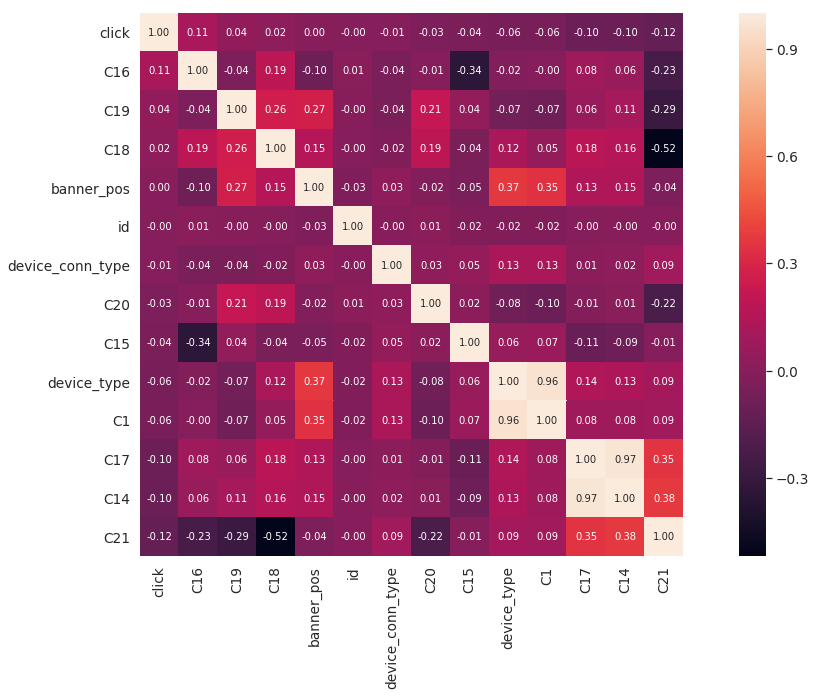

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
parse_date = lambda val :pd.datetime.strptime(val,'%y%m%d%H')
train_df = pd.read_csv('data/train2000',parse_dates=['hour'],date_parser=parse_date)
corrmat = train_df.corr()
k = 25
cols = corrmat.nlargest(k,'click')['click'].index
print(cols)
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize = (20,10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()



In [68]:
import random
import numpy as n
import pandas as pd
import gzip



In [28]:
train['click'].value_counts()/len(train)
train.head()


,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1000009418151094273,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,10000169349117863715,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,10000371904215119486,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,10000640724480838376,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,10000679056417042096,0,2014-10-21,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


In [27]:
train.hour.describe()

count                     499
unique                      1
top       2014-10-21 00:00:00
freq                      499
first     2014-10-21 00:00:00
last      2014-10-21 00:00:00
Name: hour, dtype: object

In [29]:
train.C1.value_counts()/len(train)

1005    0.929860
1002    0.038076
1010    0.032064
Name: C1, dtype: float64

In [5]:
import os
import sys
import os.path
import pyspark
#import urllib2

#response = urllib2.urlopen('https://www.dropbox.com/s/rf64jk6eufmserm/dac_sample.txt?dl=1')

#dacContents = response.read().split('\n')
file = open('data/train2000', 'r') 
dacContents = file.read().split("\n") 
dacContents = [x.strip().replace('\t', ',') for x in dacContents]

numPartitions = 2
rawData = sc.parallelize(dacContents)

In [6]:
weights = [.8, .1, .1]
seed = 42
rawTrainData, rawValidationData, rawTestData = rawData.randomSplit(weights,seed)
# Cache the data
rawTrainData.cache()
rawValidationData.cache()
rawTestData.cache()

nTrain = rawTrainData.count()
nVal = rawValidationData.count()
nTest = rawTestData.count()
print( nTrain, nVal, nTest, nTrain + nVal + nTest)
print (rawData.take(3))

1584 203 213 2000
['1000009418151094273,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,-1,79', '10000169349117863715,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,100084,79', '10000371904215119486,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,15704,320,50,1722,0,35,100084,79']


In [7]:
def parsePoint(point):
    """Converts a comma separated string into a list of (featureID, value) tuples.

    Note:
        featureIDs should start at 0 and increase to the number of features - 1.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.

    Returns:
        list: A list of (featureID, value) tuples.
    """
    
    list_features_all = point.split(",")
    list_final = []
    n = len(list_features_all)
    for i in range(1,n):
      list_final.append((i-1,list_features_all[i]))
    
    return list_final

parsedTrainFeat = rawTrainData.map(parsePoint)

numCategories = (parsedTrainFeat
                 .flatMap(lambda x: x)
                 .distinct()
                 .map(lambda x: (x[0], 1))
                 .reduceByKey(lambda x, y: x + y)
                 .sortByKey()
                 .collect())
print(numCategories)

print (numCategories[2][1])

[(0, 2), (1, 1), (2, 4), (3, 2), (4, 160), (5, 136), (6, 12), (7, 110), (8, 17), (9, 8), (10, 195), (11, 1403), (12, 435), (13, 4), (14, 4), (15, 138), (16, 3), (17, 4), (18, 81), (19, 4), (20, 31), (21, 68), (22, 24)]
4


In [8]:
from collections import defaultdict
import hashlib

def hashFunction(numBuckets, rawFeats, printMapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.

    Note:
        Use printMapping=True for debug purposes and to better understand how the hashing works.

    Args:
        numBuckets (int): Number of buckets to use as features.
        rawFeats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        printMapping (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = {}
    for ind, category in rawFeats:
        featureString = category + str(ind)
        #signature = hashlib.sha256(h.encode('utf-8')).hexdigest()
        #mapping[featureString] = int(int(hashlib.md5(featureString).hexdigest(), 16) % numBuckets)
        mapping[featureString] = int(int(hashlib.md5(featureString.encode('utf-8')).hexdigest(), 16) % numBuckets)
        
    if(printMapping): print (mapping)
    sparseFeatures = defaultdict(float)
    for bucket in mapping.values():
        sparseFeatures[bucket] += 1.0
    return dict(sparseFeatures)

In [9]:
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint
def parseHashPoint(point, numBuckets):
    """Create a LabeledPoint for this observation using hashing.

    Args:
        point (str): A comma separated string where the first value is the label and the rest are
            features.
        numBuckets: The number of buckets to hash to.

    Returns:
        LabeledPoint: A LabeledPoint with a label (0.0 or 1.0) and a SparseVector of hashed
            features.
    """
    
    list_features_all = point.split(",")
    list_final = []
    n = len(list_features_all)
    for i in range(1,n):
      list_final.append((i-1,list_features_all[i]))
   
   
    sp = SparseVector(numBuckets,hashFunction(numBuckets, list_final, True))
    
    if (list_features_all[0] == "0"):
      lbp = LabeledPoint(0,sp)
    else:
      lbp = LabeledPoint(1,sp)
  
    return lbp

numBucketsCTR = 2 ** 15
hashTrainData = rawTrainData.map(lambda x: parseHashPoint(x, numBucketsCTR))
hashTrainData.cache()
hashValidationData = rawValidationData.map(lambda x: parseHashPoint(x, numBucketsCTR))
hashValidationData.cache()
hashTestData = rawTestData.map(lambda x: parseHashPoint(x, numBucketsCTR))
hashTestData.cache()

#signature = hashlib.sha256(h.encode('utf-8')).hexdigest()
print( hashTrainData.take(4))

[LabeledPoint(1.0, (32768,[613,842,2147,4814,5675,5714,6026,6518,7382,7934,12023,12855,13017,13603,16499,21430,21822,21896,25298,26049,26056,27031,30072],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])), LabeledPoint(1.0, (32768,[2118,2147,4814,5675,5714,6026,7382,7934,8115,12855,13017,13603,15370,16499,19111,21430,21822,21896,25298,26049,26056,27031,32496],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])), LabeledPoint(1.0, (32768,[2147,4814,5675,5714,6026,7382,7934,8115,12855,13017,13603,15370,16499,19111,21430,21822,21896,22464,24856,25298,26049,26056,27031],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])), LabeledPoint(1.0, (32768,[1030,2147,4814,5675,5714,6026,7382,7934,8115,12855,13017,13603,15485,16499,19111,21430,21822,21896,25298,26049,26056,27031,30072],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1

In [10]:
def evaluateResults(model, data):
    """Calculates the log loss for the data given the model.

    Args:
        model (LogisticRegressionModel): A trained logistic regression model.
        data (RDD of LabeledPoint): Labels and features for each observation.

    Returns:
        float: Log loss for the data.
    """
    
    return data.map(lambda x: computeLogLoss(getP(x.features, model.weights, model.intercept),x.label)).mean()

In [11]:
from math import log

def computeLogLoss(p, y):
    """Calculates the value of log loss for a given probabilty and label.

    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon) from it.

    Args:
        p (float): A probabilty between 0 and 1.
        y (int): A label.  Takes on the values 0 and 1.

    Returns:
        float: The log loss value.
    """
    epsilon = 10e-12
    
    if p==0:
      p+=epsilon
    elif p==1:
      p-=epsilon
    
    if y==1:
      logloss = -log(p)
    elif y==0:
      logloss = -log(1-p)
    
    return logloss

In [12]:
from math import exp #  exp(-t) = e^-t

def getP(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.

    Note:
        We'll bound our raw prediction between 20 and -20 for numerical purposes.

    Args:
        x (SparseVector): A vector with values of 1.0 for features that exist in this
            observation and 0.0 otherwise.
        w (DenseVector): A vector of weights (betas) for the model.
        intercept (float): The model's intercept.

    Returns:
        float: A probability between 0 and 1.
    """
    
    rawPrediction = x.dot(w) + intercept
    
    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    return 1/(1+exp(-rawPrediction))

In [13]:
from pyspark.mllib.classification import LogisticRegressionWithSGD
numIters = 500
regType = 'l2'
includeIntercept = True

# Initialize variables using values from initial model training
bestModel = None
bestLogLoss = 1e10

In [14]:
stepSizes = [1,10]
regParams = [1e-6,1e-3]
for stepSize in stepSizes:
    print("#stepSize",stepSize)
    for regParam in regParams:
        model = (LogisticRegressionWithSGD
                 .train(hashTrainData, numIters, stepSize, regParam=regParam, regType=regType,
                        intercept=includeIntercept))
        logLossVa = evaluateResults(model, hashValidationData)
        print ('\tstepSize = {0:.1f}, regParam = {1:.0e}: logloss = {2:.3f}'
               .format(stepSize, regParam, logLossVa))
        if (logLossVa < bestLogLoss):
            bestModel = model
            bestLogLoss = logLossVa

print(type(bestLogLoss))
print(bestLogLoss)
#print ('Hashed Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
print ('Hashed Features Validation Logloss:\tLogReg = {}'
       .format(bestLogLoss))
#       .format(logLossValBase, bestLogLoss))
#stepSize = 1.0, regParam = 1e-06: logloss = 0.470
#stepSize = 1.0, regParam = 1e-03: logloss = 0.470
#stepSize = 10.0, regParam = 1e-06: logloss = 0.446
#stepSize = 10.0, regParam = 1e-03: logloss = 0.448
#Hashed Features Validation Logloss:
#Baseline = 0.523
#LogReg = 0.446

#stepSize 1
	stepSize = 1.0, regParam = 1e-06: logloss = 0.004
	stepSize = 1.0, regParam = 1e-03: logloss = 0.005
#stepSize 10
	stepSize = 10.0, regParam = 1e-06: logloss = 0.000
	stepSize = 10.0, regParam = 1e-03: logloss = 0.000
<class 'float'>
2.061153694291927e-09
Hashed Features Validation Logloss:	LogReg = 2.061153694291927e-09


__`REMINDER:`__ If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

# Question 1: Question Formulation 
Introduce the goal of your analysis. What questions will you seek to answer, why do people perform this kind of analysis on this kind of data? Preview what level of performance your model would need to achieve to be practically useful.

# Question 2: Algorithm Explanation
Create your own toy example that matches the dataset provided and use this toy example to explain the math behind the algorithym that you will perform.

# Question 3: EDA & Discussion of Challenges
Determine 2-3 relevant EDA tasks that will help you make decisions about how you implement the algorithm to be scalable. Discuss any challenges that you anticipate based on the EDA you perform

In [11]:
average_CTR = projectRDD.map(lambda x: int(x.split('\t')[0])).mean()

In [12]:
average_CTR

0.25622338372976045

# Question 4: Algorithm Implementation 
Develop a 'homegrown' implementation of the algorithn, apply it to the training dataset and evaluate your results on the test set. 

# Question 5: Application of Course Concepts
Pick 3-5 key course concepts and discuss how your work on this assignment illustrates an understanding of these concepts. 